# 作業 : (Kaggle)鐵達尼生存預測

# [教學目標]
- 以下用鐵達尼預測資料, 展示如何使用葉編碼, 並觀察預測效果
- 因為只有分類問題比較適合葉編碼, 因此範例與作業都使用鐵達尼的資料(二元分類問題)

# [教學目標]
- 了解葉編碼的寫作方式 : 使用梯度提升樹 (In[3]~In[5], Out[3]~Out[5])
- 觀察葉編碼搭配邏輯斯迴歸後的效果 (In[6], Out[6], In[7], Out[7])

In [1]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
# 因為擬合(fit)與編碼(transform)需要分開, 因此不使用.get_dummy, 而採用 sklearn 的 OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

data_path = 'data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

C:\Users\Bryan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [3]:
train_X = df.values
# 因為訓練邏輯斯迴歸時也要資料, 因此將訓練及切成三部分 train / val / test, 採用 test 驗證而非 k-fold 交叉驗證
# train 用來訓練梯度提升樹, val 用來訓練邏輯斯迴歸, test 驗證效果
train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.5)
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.5)

In [4]:
# 梯度提升樹調整參數並擬合後, 再將葉編碼 (*.apply) 結果做獨熱 / 邏輯斯迴歸
# 調整參數的方式採用 RandomSearchCV 或 GridSearchCV, 以後的進度會再教給大家, 本次先直接使用調參結果
gdbt = GradientBoostingClassifier(subsample=0.93, n_estimators=320, min_samples_split=0.1, min_samples_leaf=0.3, 
                                  max_features=4, max_depth=4, learning_rate=0.16)
onehot = OneHotEncoder()
lr = LogisticRegression(solver='lbfgs', max_iter=1000)

gdbt.fit(train_X, train_Y)
onehot.fit(gdbt.apply(train_X)[:, :, 0])
lr.fit(onehot.transform(gdbt.apply(val_X)[:, :, 0]), val_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [5]:
gdbt.apply(train_X)[:, :, 0]

array([[2., 2., 2., ..., 4., 1., 1.],
       [1., 2., 1., ..., 2., 3., 1.],
       [2., 2., 1., ..., 2., 3., 1.],
       ...,
       [2., 2., 1., ..., 2., 3., 1.],
       [2., 2., 1., ..., 4., 3., 1.],
       [1., 2., 1., ..., 4., 4., 2.]])

In [6]:
# 將梯度提升樹+葉編碼+邏輯斯迴歸結果輸出
pred_gdbt_lr = lr.predict_proba(onehot.transform(gdbt.apply(test_X)[:, :, 0]))[:, 1]
fpr_gdbt_lr, tpr_gdbt_lr, _ = roc_curve(test_Y, pred_gdbt_lr)
# 將梯度提升樹結果輸出
pred_gdbt = gdbt.predict_proba(test_X)[:, 1]
fpr_gdbt, tpr_gdbt, _ = roc_curve(test_Y, pred_gdbt)

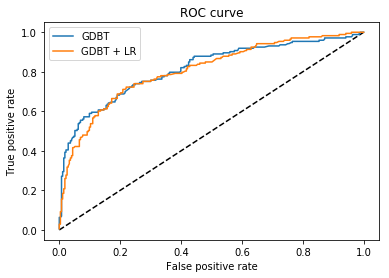

In [8]:
import matplotlib.pyplot as plt
# 將結果繪圖
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gdbt, tpr_gdbt, label='GDBT')
plt.plot(fpr_gdbt_lr, tpr_gdbt_lr, label='GDBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# 作業1
* 請對照範例，完成隨機森林的鐵達尼生存率預測，以及對應的葉編碼+邏輯斯迴歸

# 作業2
* 上述的結果，葉編碼是否有提高預測的正確性呢?